# Forecast Energy Consumption with XGboost + Crossvalidation- P2

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/energy.jpg" width="2000">

In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/PJME_hourly.csv

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_csv('PJME_hourly.csv',
                index_col = 'Datetime',
                parse_dates = True
                )
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


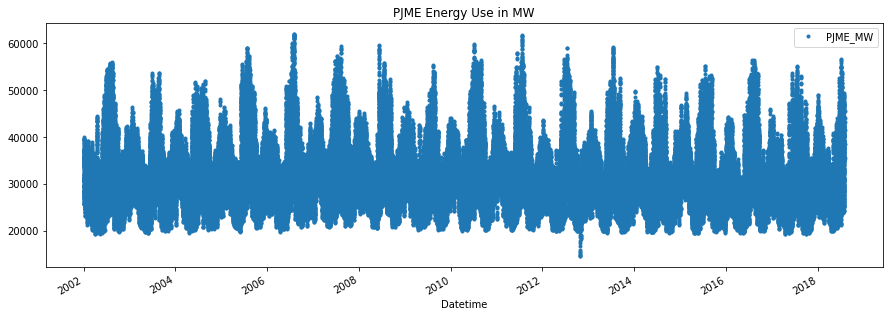

In [23]:
df.plot(style='.',
        figsize=(15, 5),
        #color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## 1. Outlier Analysis and removal

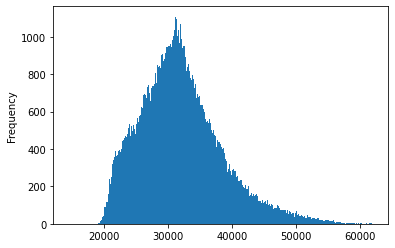

In [24]:
df['PJME_MW'].plot(kind='hist', bins=500);

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

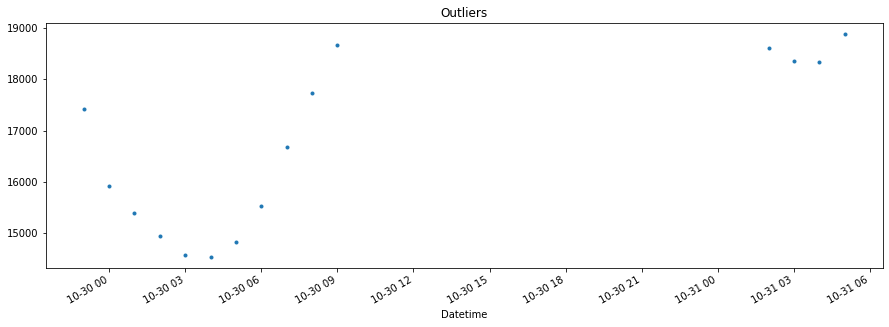

In [25]:
#treshold
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          #color=color_pal[5],
          title='Outliers')

In [26]:
#over than filter outliers
df = df.query('PJME_MW > 19_000').copy()
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


## 2. Reviewing: Train / Test Split

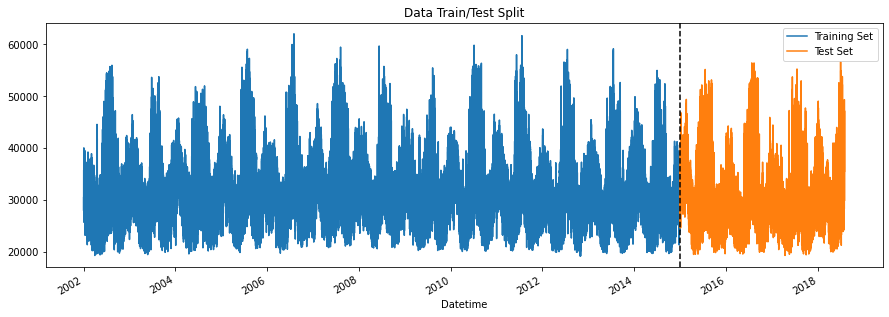

In [27]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## 3. Time Series Cross Validation - Sklearn TimeSeriesSplit

In [28]:
#TIME SERIES CROSS VALIDATION SPLIT
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

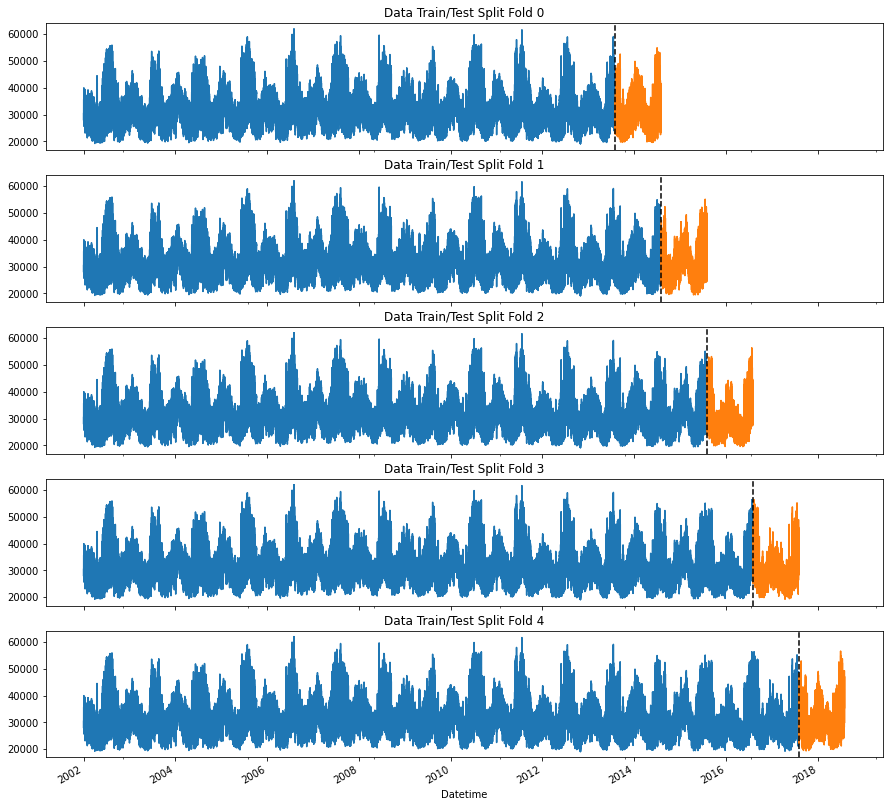

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [30]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [31]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [32]:
df = add_lags(df)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0


## 4. Train Using Cross Validation

In [33]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rmse:5755.14393	validation_1-rmse:5649.54800
[300]	validation_0-rmse:3909.18294	validation_1-rmse:3930.98277
[400]	validation_0-rmse:3477.91771	validation_1-rmse:3603.77859
[500]	validation_0-rmse:3356.63775	validation_1-rmse:3534.18452
[600]	validation_0-rmse:3299.24378	validation_1-rmse:3495.69013
[700]	validation_0-rmse:3258.86466	validation_1-rmse:3470.24780
[800]	validation_0-rmse:3222.68998	validation_1-rmse:3446.36557
[900]	validation_0-rmse:3195.04645	v

In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3750.6406
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


## 5. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [35]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:41:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [36]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [37]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [38]:
future_w_features = df_and_future.query('isFuture').copy()

## 6. Predict the future

In [39]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
future_w_features[FEATURES]

,dayofyear,hour,dayofweek,quarter,month,year,lag1,lag2,lag3
2018-08-03 00:00:00,215,0,4,3,8,2018,33539.0,32094.0,31695.0
2018-08-03 01:00:00,215,1,4,3,8,2018,30781.0,29503.0,29128.0
2018-08-03 02:00:00,215,2,4,3,8,2018,29015.0,27712.0,27373.0
2018-08-03 03:00:00,215,3,4,3,8,2018,27884.0,26535.0,26233.0
2018-08-03 04:00:00,215,4,4,3,8,2018,27223.0,25870.0,25643.0
...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,212,20,2,3,7,2019,46912.0,39352.0,40243.0
2019-07-31 21:00:00,212,21,2,3,7,2019,45985.0,38699.0,39183.0
2019-07-31 22:00:00,212,22,2,3,7,2019,44094.0,37346.0,37759.0
2019-07-31 23:00:00,212,23,2,3,7,2019,40666.0,34555.0,34641.0


In [43]:
future_w_features['pred'] = model.predict(future_w_features[FEATURES])
future_w_features['pred']

2018-08-03 00:00:00    30756.787109
2018-08-03 01:00:00    28554.314453
2018-08-03 02:00:00    28016.724609
2018-08-03 03:00:00    27383.017578
2018-08-03 04:00:00    27072.333984
                           ...     
2019-07-31 20:00:00    42223.007812
2019-07-31 21:00:00    41444.980469
2019-07-31 22:00:00    40697.593750
2019-07-31 23:00:00    38344.351562
2019-08-01 00:00:00    32243.312500
Name: pred, Length: 8713, dtype: float32

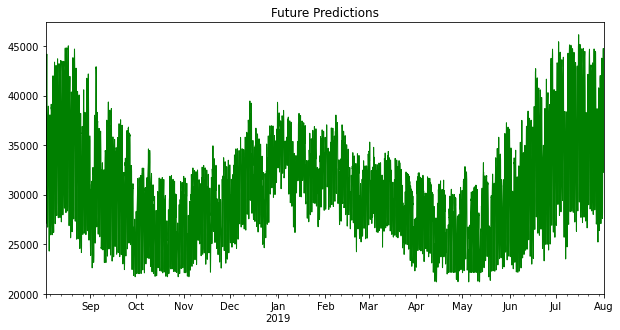

In [44]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='green',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Saving Model

In [45]:
# Save model
import joblib

joblib.dump(model,'model_XGB.pkl')

['model_XGB.pkl']

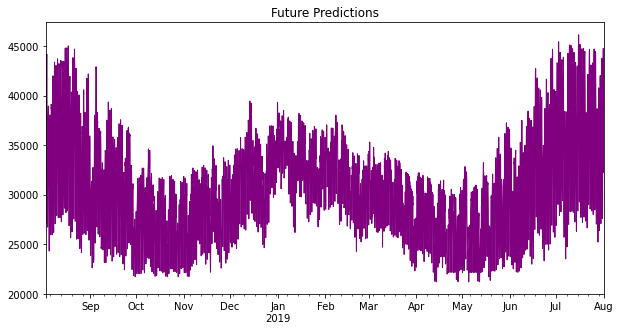

In [47]:
model_load = joblib.load('model_XGB.pkl')
future_w_features['pred'] = model_load.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color='purple',
                               ms=1, 
                               lw=1,
                               title='Future Predictions');